# Analysis

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import pandas as pd
import ast

data_file = "AA_CCLE_hg38_aggregated_050323/aggregated_results.csv"
df = pd.read_csv(
    data_file
        ).rename(columns={'Tissue of origin':"tissue_of_origin"}
        ).query("Classification == 'ecDNA'"
        ).query("tissue_of_origin == 'lung'")

oncogenes = df["Oncogenes"]
genes = df["All genes"]

oncogenes_set = set()
for l in oncogenes:
    for item in ast.literal_eval(l):
        oncogenes_set.add(item)
genes_set = set()
for l in genes:
    for item in ast.literal_eval(l):
        genes_set.add(item)

with open("lung_oncogenes", "w") as f:
    for oncogene in oncogenes_set:
        f.write(oncogene+"\n")
with open("lung_genes", "w") as f:
    for gene in genes_set:
        f.write(gene+"\n")

In [ ]:
gene_count = {}
for l in genes:
    for item in ast.literal_eval(l):
        gene_count[item] = gene_count.setdefault(item, 0) + 1 

genes = gene_count.keys()
oncogene = [False]*len(genes)
for i, gene in enumerate(genes):
    if gene in oncogenes_set:
        oncogene[i] = True


In [ ]:
len(oncogene)

1081

In [ ]:
df = pd.DataFrame(
    {
        "gene":list(genes), 
        "count":list(gene_count.values()), 
        "oncogene":list(oncogene)
    }
)

In [ ]:
df.sort_values(by=["count"], ascending = False).head(20)

,gene,count,oncogene
104,CASC11,16,False
111,MYC,16,True
115,PVT1,12,True
86,MYCL,11,False
100,TRIT1,11,False
113,POU5F1B,10,False
84,HPCAL4,10,False
89,NT5C1A,10,False
90,OXCT2,10,False
94,PPIE,10,False


/Users/willardwashingtonford/Library/Python/3.9/lib/python/site-packages/seaborn/categorical.py:3543: UserWarning: 84.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/willardwashingtonford/Library/Python/3.9/lib/python/site-packages/seaborn/categorical.py:3543: UserWarning: 14.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/willardwashingtonford/Library/Python/3.9/lib/python/site-packages/seaborn/categorical.py:3543: UserWarning: 86.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/willardwashingtonford/Library/Python/3.9/lib/python/site-packages/seaborn/categorical.py:3543: UserWarning: 33.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(ms

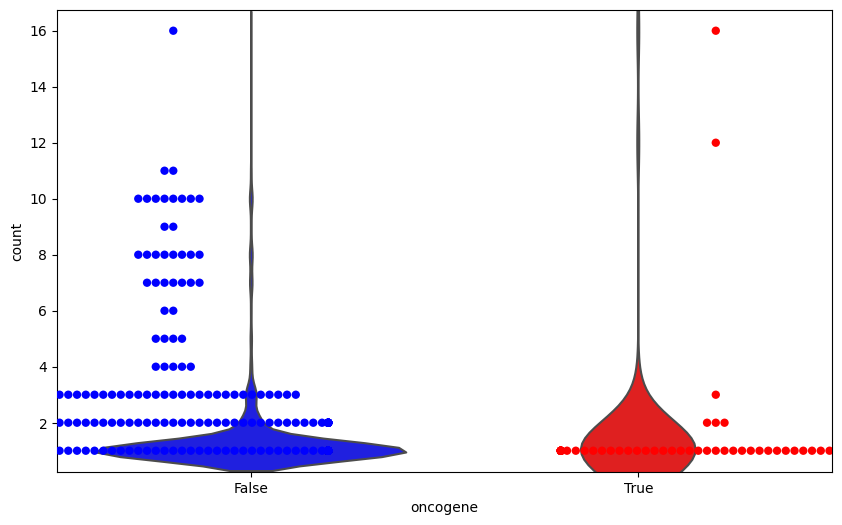

In [18]:
plt.figure(figsize=(10, 6))

# Create a violin plot
sns.violinplot(x='oncogene', y='count', data=df, inner=None, 
    palette={True: "red", False: "blue"})

# Add swarmplot to show individual points
sns.swarmplot(x='oncogene', y='count', data=df, hue='oncogene', 
              palette={True: "red", False: "blue"}, dodge=True, size=6)

# Remove the legend as we already have color coding
plt.legend([],[], frameon=False)

# Show the plot
plt.show()

In [19]:
df_onco = df.query("oncogene == True")["count"]
df_notonco = df.query("oncogene == False")["count"]

onco_vc = df_onco.value_counts()
nonco_vc = df_notonco.value_counts()

counts_df = pd.DataFrame(onco_vc).join(pd.DataFrame(nonco_vc), 
    lsuffix='-onco', rsuffix='-non-onco', how= "outer").fillna(0)

full_index = pd.Index(range(counts_df.index.min(), counts_df.index.max() + 1))
counts_df = counts_df.reindex(full_index, fill_value=0.0)

counts_df["prob-onco"] = counts_df["count-onco"]/sum(counts_df["count-onco"])
counts_df["prob-non-onco"] = counts_df["count-non-onco"]/sum(counts_df["count-non-onco"])

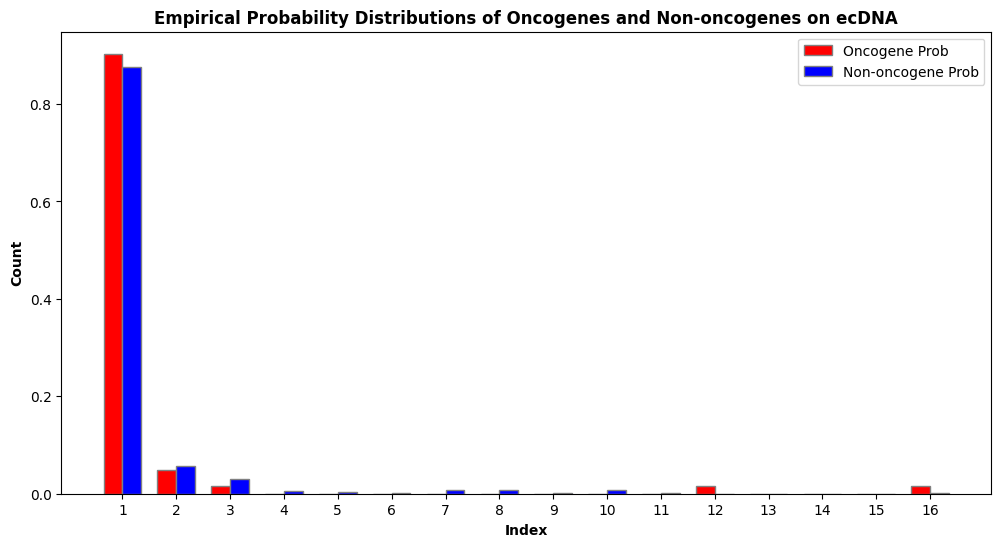

In [23]:
bar_width = 0.35

r1 = np.arange(len(counts_df))
r2 = [x + bar_width for x in r1]

# Create the bar plot
plt.figure(figsize=(12, 6))
plt.bar(r1, counts_df['prob-onco'], color='red', width=bar_width, 
    edgecolor='grey', label='Oncogene Prob')
plt.bar(r2, counts_df['prob-non-onco'], color='blue', width=bar_width, 
    edgecolor='grey', label='Non-oncogene Prob')

# Adding labels and title
plt.xlabel('Index', fontweight='bold')
plt.ylabel('Count', fontweight='bold')
plt.title('Empirical Probability Distributions of Oncogenes and Non-oncogenes on ecDNA', 
    fontweight='bold')
plt.xticks([r + bar_width/2 for r in range(len(counts_df))], counts_df.index)

# Adding legend
plt.legend()

# Show the plot
plt.show()

### Proposed framework for analyzing ecDNA with regard to Cancer Cell Lines

We should analyze the data at 3 different levels of granularity

1. Looking at over-represented genes in ecDNA
    - Especially oncogenes (but other genes and tumor suppressors are also interesting)
2. Looking at over-represented regions in ecDNA
    - Enhancers are not in genes
    - bed file analysis
    - chr3 600 700
3. Looking at over-represented sequences in ecDNA
    - Motif is repeated across multiple regions
    - Alignment Algorithms

At each level which should generate perform roughly the following analysis:

- Find a Null Distribution of the probability of seeing these results assuming they segmented at random. (Note that ecDNA may not form uniformly accross the genome)

- Then find genes/regions/sequences that are statistically significant and over-represented. We can generate p-values here.

- Investigate those genes/regions/sequences to see if they correlate to some known cancerous traits. 
    - A positive result would indicate a positive control.
    - A negative result might be even more exciting and could indicate a novel sequence that interacts with cancer in some way through ecDNA.

Plus our final question gives 4 different aspects to attack for the project.

4. Why do RNAi knockouts in the database have higher viability across the board than CRIPSRi?


## Scratch Notes:

**What's the probability of a gene appearing at random k times?**


How likely is it that an ecDNA segments a gene * Number of ecDNA

Length of all genes / Length of Genome * number of ecDNA

But we have to take into account that some regions are more likely to become ecDNA and that some genes have different lengths. How is it that a gene is counted as present on an ecDNA segment. Does the whole gene have to be present? How long are the genes and how long are the ecDNA segments?

Then we can determine the expected number above some value which is probably pretty low for the oncogenes in general. We can generate a background distribution then take the values above some p-value threshold. 

Then can also generalize this to non-genes in an interesting way by just looking at segments in general. We'd then have to deal with overlaps of non-gene regions but I bet it's still possible. This seems like a very solvable problem to then highlight some interesting sequences that are over-represented. Then we can simply dive into thos sequences specifically and see what they show. They will probably be oncogenes but I bet there are several other regions that appear at a statistically interesting rate as well. 

We could also instead of looking for regions of the genome, if our sequence of interest is small enough (like an enhancer of 20bp or so) we could start looking for specific sequences that are overrepresented that are non-genic then see if we find anything interesting there. Then don't even have to be non-genic regions. What if we find that genes with a specific sequence are over-represented in the ecDNA because they can actually act as enhancers for other genes. 

I'm just spitballing but wouldn't that be cool.

This framework also gives several avenues of attack that have increasing levels of granularity:


In [20]:
import re

lung_bed = "Lung_ecDNA.bed"
data_file = "AA_CCLE_hg38_aggregated_050323/aggregated_results.csv"
df = pd.read_csv(
    data_file
        ).rename(columns={'Tissue of origin':"tissue_of_origin"}
        ).query("Classification == 'ecDNA'"
        ).query("tissue_of_origin == 'lung'")

In [19]:
df.Location[19]

"['chr20:537320-1408502', 'chr20:1410170-1580396', 'chr20:1613533-1804925']"

In [21]:
def toBed(string_ranges):
    output = []
    string_ranges = re.sub("['| |\]|\[|']","",string_ranges)
    bed_ranges = string_ranges.split(",")
    for br in bed_ranges:
        bed_format_range =  "\t".join(re.split("[-|:]", br))
        output.append(bed_format_range)
    return output

regions = []
for l in df.Location:
    regions += toBed(l)

bed_regions = "\n".join(regions)

with open(lung_bed, "w") as f:
    f.write(bed_regions)

Get seqs from bedfiles

```
bedtools getfasta -fo Lung_ecDNA.fa -fi data/hg38.fa.gz -bed Lung_ecDNA.bed
```

bgzip -i is used to make hg38.fa.gz

```
kmer-counter/kmer-counter --k=6 --fasta Lung_ecDNA.fa --rc --results-dir=Lung_ecKMER.counts
```

In [65]:
counts_file = "Lung_ec_kmer-counter/count.txt"

df = pd.read_csv(counts_file, 
    header=None, 
    sep = "[|\t| ]",
    engine="python"
    )

# Put into kmer x region counts matrix
kmer_columns = {}
# Loop through each row and column to extract k-mer counts
for idx, row in df.iterrows():
    for col in row.index[1:]:  # Skip the first column (region info)
        try:
            kmer, count = row[col].split(':')
            count = int(count)
            if kmer not in kmer_columns:
                kmer_columns[kmer] = [0] * len(df)
            kmer_columns[kmer][idx] = count
        except:
            pass

kmer_df = pd.DataFrame(kmer_columns)

# Add counts labels
kmer_df.insert(0, 'Region', df.iloc[:, 0])
kmer_df["Region"] = kmer_df["Region"].str.replace('>', '')
kmer_df = kmer_df.set_index("Region")

In [69]:
kmer_df.to_csv("Lung_ec_6mer.counts", sep="\t")

In [68]:
kmer_df.head()

,GCCTCA,CTTCGA,AAGTCC,AACGGA,TAACGA,CCGTTA,ACCGCT,TTAGAA,CCGCGC,ACATAA,...,GGTCGA,AAATAA,CATCGG,ACGCTA,GGAGTA,AGCGAC,GTGATA,GTGCAC,CCCTCC,CCACGC
Region,,,,,,,,,,,,,,,,,,,,,
chr4:161967909-162770269,389,31,290,49,39,33,23,924,25,939,...,15,2978,24,26,242,19,436,103,260,73
chr20:537320-1408502,1049,50,396,74,48,35,70,567,107,493,...,44,1458,73,42,294,58,297,184,1160,222
chr20:1410170-1580396,170,8,127,12,10,8,14,128,9,105,...,6,329,13,4,52,12,64,39,140,19
chr20:1613533-1804925,162,14,111,20,16,12,9,159,8,141,...,10,340,5,9,55,6,77,40,167,27
chr13:90413676-91826022,814,94,604,96,90,64,46,1685,47,1528,...,32,4590,49,62,410,42,705,187,626,137
